In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import neural_structured_learning as nsl
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
# setup hyper-parameters

class HParams(object):
  def __init__(self):
    self.input_shape = [28, 28, 1]
    self.num_classes = 10
    self.conv_filters = [32, 64, 64]
    self.kernel_size = (3, 3)
    self.pool_size = (2, 2)
    self.num_fc_units = [64]
    self.batch_size = 32
    self.epochs = 5
    self.adv_multiplier = 0.2
    self.adv_step_size = 0.2
    self.adv_grad_norm = 'infinity'

HPARAMS = HParams()

In [3]:
# download datasets
datasets = tfds.load('mnist')

train_dataset = datasets['train']
test_dataset = datasets['test']

IMAGE_INPUT_NAME = 'image'
LABEL_INPUT_NAME = 'label'

/home/jason543/anaconda3/envs/tf20/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/jason543/anaconda3/envs/tf20/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/jason543/anaconda3/envs/tf20/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/jason543/anaconda3/envs/tf20/lib/python3.6/

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset mnist downloaded and prepared to /home/jason543/tensorflow_datasets/mnist/1.0.0. Subsequent calls will reuse this data.


In [4]:
# normalize datasets
def normalize(features):
  features[IMAGE_INPUT_NAME] = tf.cast(
      features[IMAGE_INPUT_NAME], dtype=tf.float32) / 255.0
  return features

def convert_to_tuples(features):
  return features[IMAGE_INPUT_NAME], features[LABEL_INPUT_NAME]

def convert_to_dictionaries(image, label):
  return {IMAGE_INPUT_NAME: image, LABEL_INPUT_NAME: label}

train_dataset = train_dataset.map(normalize).shuffle(10000).batch(HPARAMS.batch_size).map(convert_to_tuples)
test_dataset = test_dataset.map(normalize).batch(HPARAMS.batch_size).map(convert_to_tuples)

In [5]:
# define model
def build_base_model(hparams):
  """Builds a model according to the architecture defined in `hparams`."""
  inputs = tf.keras.Input(
      shape=hparams.input_shape, dtype=tf.float32, name=IMAGE_INPUT_NAME)

  x = inputs
  for i, num_filters in enumerate(hparams.conv_filters):
    x = tf.keras.layers.Conv2D(
        num_filters, hparams.kernel_size, activation='relu')(
            x)
    if i < len(hparams.conv_filters) - 1:
      # max pooling between convolutional layers
      x = tf.keras.layers.MaxPooling2D(hparams.pool_size)(x)
  x = tf.keras.layers.Flatten()(x)
  for num_units in hparams.num_fc_units:
    x = tf.keras.layers.Dense(num_units, activation='relu')(x)
  pred = tf.keras.layers.Dense(hparams.num_classes, activation='softmax')(x)
  model = tf.keras.Model(inputs=inputs, outputs=pred)
  return model

In [6]:
# initialize model
base_model = build_base_model(HPARAMS)
base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0     

In [7]:
# train model
base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
base_model.fit(train_dataset, epochs=HPARAMS.epochs)

Epoch 1/5
1875/1875 [==============================] - 18s 10ms/step - loss: 0.1462 - accuracy: 0.9551
Epoch 2/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0455 - accuracy: 0.9859
Epoch 3/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0321 - accuracy: 0.9898
Epoch 4/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0248 - accuracy: 0.9918
Epoch 5/5
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0190 - accuracy: 0.9939


In [8]:
results = base_model.evaluate(test_dataset)
named_results = dict(zip(base_model.metrics_names, results))
print('accuracy:', named_results['accuracy'])

313/313 [==============================] - 1s 3ms/step - loss: 0.0302 - accuracy: 0.9912
accuracy: 0.9912


In [9]:
# setup adversarial perturbed training
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=HPARAMS.adv_multiplier,
    adv_step_size=HPARAMS.adv_step_size,
    adv_grad_norm=HPARAMS.adv_grad_norm
)

In [10]:
base_adv_model = build_base_model(HPARAMS)
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config
)

train_set_for_adv_model = train_dataset.map(convert_to_dictionaries)
test_set_for_adv_model = test_dataset.map(convert_to_dictionaries)

In [11]:
adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
adv_model.fit(train_set_for_adv_model, epochs=HPARAMS.epochs)

Epoch 1/5
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2932 - sparse_categorical_crossentropy: 0.1378 - sparse_categorical_accuracy: 0.9583 - adversarial_loss: 0.7773
Epoch 2/5
1875/1875 [==============================] - 20s 11ms/step - loss: 0.1171 - sparse_categorical_crossentropy: 0.0401 - sparse_categorical_accuracy: 0.9877 - adversarial_loss: 0.3851
Epoch 3/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0790 - sparse_categorical_crossentropy: 0.0288 - sparse_categorical_accuracy: 0.9912 - adversarial_loss: 0.2512
Epoch 4/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0634 - sparse_categorical_crossentropy: 0.0227 - sparse_categorical_accuracy: 0.9926 - adversarial_loss: 0.2036
Epoch 5/5
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0480 - sparse_categorical_crossentropy: 0.0182 - sparse_categorical_accuracy: 0.9942 - adversarial_loss: 0.1489


In [12]:
# evaluate results with adv_network
results = adv_model.evaluate(test_set_for_adv_model)
named_results = dict(zip(adv_model.metrics_names, results))
print('accuracy:', named_results['sparse_categorical_accuracy'])

313/313 [==============================] - 2s 7ms/step - loss: 0.0700 - sparse_categorical_crossentropy: 0.0313 - sparse_categorical_accuracy: 0.9913 - adversarial_loss: 0.1936
accuracy: 0.9913


In [13]:
# test robustness of these 2 models against adversarial examples
reference_model = nsl.keras.AdversarialRegularization(
    base_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config)
reference_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [14]:
models_to_eval = {
    'base': base_model,
    'adv-regularized': adv_model.base_model
}
metrics = {
    name: tf.keras.metrics.SparseCategoricalAccuracy()
    for name in models_to_eval.keys()
}

In [15]:
perturbed_images, labels, predictions = [], [], []

for batch in test_set_for_adv_model:
  perturbed_batch = reference_model.perturb_on_batch(batch)
  # Clipping makes perturbed examples have the same range as regular ones.
  perturbed_batch[IMAGE_INPUT_NAME] = tf.clip_by_value(                          
      perturbed_batch[IMAGE_INPUT_NAME], 0.0, 1.0)
  y_true = perturbed_batch.pop(LABEL_INPUT_NAME)
  perturbed_images.append(perturbed_batch[IMAGE_INPUT_NAME].numpy())
  labels.append(y_true.numpy())
  predictions.append({})
  for name, model in models_to_eval.items():
    y_pred = model(perturbed_batch)
    metrics[name](y_true, y_pred)
    predictions[-1][name] = tf.argmax(y_pred, axis=-1).numpy()

for name, metric in metrics.items():
  print('%s model accuracy: %f' % (name, metric.result().numpy()))

base model accuracy: 0.523200
adv-regularized model accuracy: 0.954000


accuracy in batch 0:
base model: 14 / 32
adv-regularized model: 30 / 32


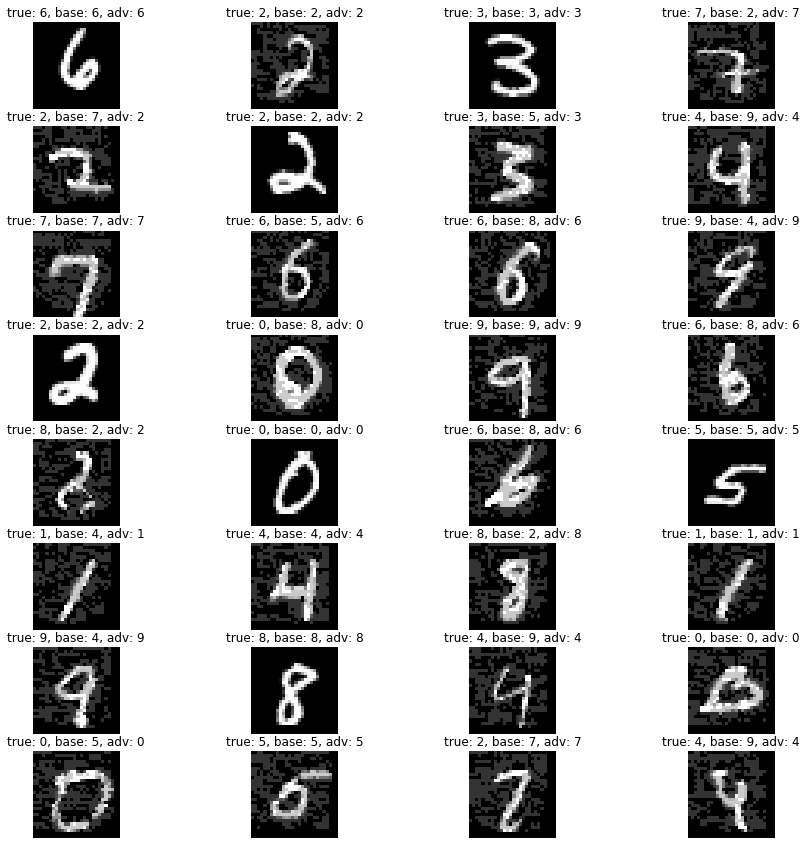

In [16]:
# visualize adversarially perturbed images:
batch_index = 0

batch_image = perturbed_images[batch_index]
batch_label = labels[batch_index]
batch_pred = predictions[batch_index]

batch_size = HPARAMS.batch_size
n_col = 4
n_row = (batch_size + n_col - 1) / n_col

print('accuracy in batch %d:' % batch_index)
for name, pred in batch_pred.items():
  print('%s model: %d / %d' % (name, np.sum(batch_label == pred), batch_size))

plt.figure(figsize=(15, 15))
for i, (image, y) in enumerate(zip(batch_image, batch_label)):
  y_base = batch_pred['base'][i]
  y_adv = batch_pred['adv-regularized'][i]
  plt.subplot(n_row, n_col, i+1)
  plt.title('true: %d, base: %d, adv: %d' % (y, y_base, y_adv))
  plt.imshow(tf.keras.preprocessing.image.array_to_img(image), cmap='gray')
  plt.axis('off')

plt.show()